In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Mol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdqueries

In [2]:
IPythonConsole.drawOptions.addAtomIndices = True

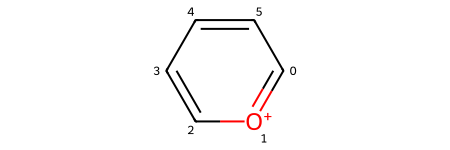

In [3]:
o_arene_sml = "C1=[O+]C=CC=C1"
o_arene = Chem.MolFromSmiles(o_arene_sml)
o_arene

In [4]:
o_aromatic_smarts = "o"
o_aromatic_smarts_mol = Chem.MolFromSmarts(o_aromatic_smarts)
# Check whether o_arene matches SMARTS pattern
o_arene.HasSubstructMatch(o_aromatic_smarts_mol)

True

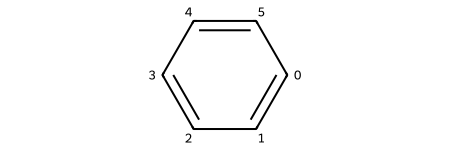

In [5]:
benzene_sml = "c1ccccc1"
benzene = Chem.MolFromSmiles(benzene_sml)
benzene

In [6]:
benzene.HasSubstructMatch(o_aromatic_smarts_mol)

False

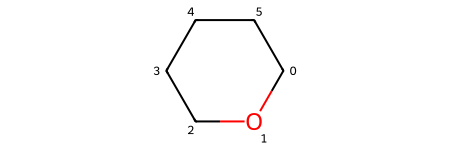

In [7]:
o_alicyclic_sml = "C1OCCCC1"
o_alicyclic = Chem.MolFromSmiles(o_alicyclic_sml)
o_alicyclic

In [8]:
o_alicyclic.HasSubstructMatch(o_aromatic_smarts_mol)

False

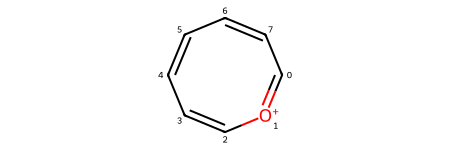

In [9]:
o_arene8_sml = "C1=[O+]C=CC=CC=C1"
o_arene8 = Chem.MolFromSmiles(o_arene8_sml)
o_arene8

In [10]:
o_arene8.HasSubstructMatch(o_aromatic_smarts_mol)

False

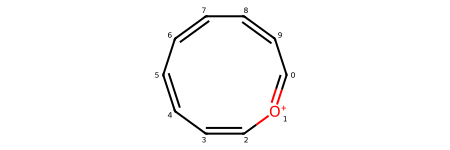

In [11]:
o_arene10_sml = "C1=[O+]C=CC=CC=CC=C1"
o_arene10 = Chem.MolFromSmiles(o_arene10_sml)
o_arene10

In [12]:
o_arene10.HasSubstructMatch(o_aromatic_smarts_mol)

True

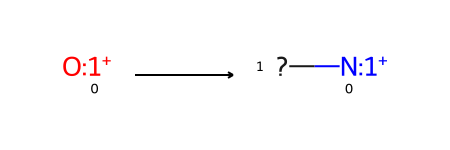

In [13]:
arene_o_to_n = "[o+:1]>>[n+:1]-[R]"
arene_o_to_n_rxn = AllChem.ReactionFromSmarts(arene_o_to_n)
arene_o_to_n_rxn

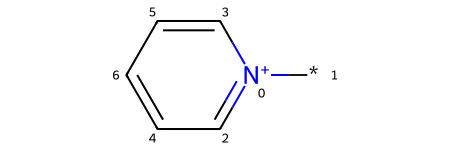

In [14]:
# Run the reaction on the o-arene molecule
o_arene_n = arene_o_to_n_rxn.RunReactants((o_arene,))[0][0]
Chem.SanitizeMol(o_arene_n)
o_arene_n

In [15]:
def run_rxn(rxn_sml, mol):
    try:
        products = arene_o_to_n_rxn.RunReactants((mol,))
    except IndexError:
        print("Starting material does not match reaction SMARTS")
        return None
    return products

In [16]:
products = run_rxn(arene_o_to_n, o_arene)

Reactant: 


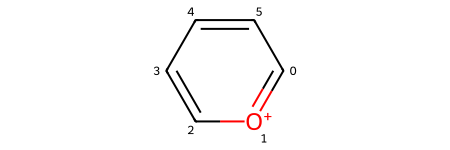

Products:


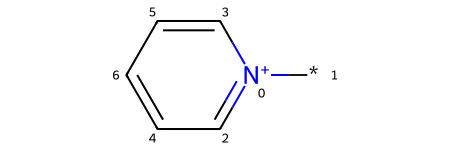

In [24]:
result = [item for t in products for item in t]
print("Reactant: ")
display(o_arene)
print("Products:")
for product in products:
    display(product[0])

In [18]:
run_rxn(arene_o_to_n, o_arene8)

()

In [19]:
run_rxn(arene_o_to_n, o_arene10)

((<rdkit.Chem.rdchem.Mol at 0x117d06030>,),)

## Accomplish the same transformation using RDKit atom substitution

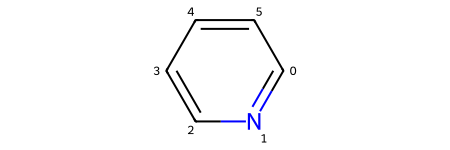

In [20]:
rwm = Chem.RWMol(o_arene)
rwm.ReplaceAtom(1,Chem.Atom(7))
Chem.SanitizeMol(rwm)
rwm

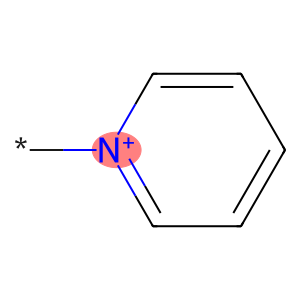

In [21]:
added_atom_idx = rwm.AddAtom(Chem.Atom("*"))
rwm.AddBond(1,added_atom_idx,Chem.BondType.SINGLE)
n_query = rdqueries.AtomNumEqualsQueryAtom(7)
n_at = rwm.GetAtomsMatchingQuery(n_query)[0]
n_at.SetNoImplicit(True)
n_at.SetNumExplicitHs(0)
n_at.SetFormalCharge(1)
Draw.MolToImage(rwm, highlightAtoms=[n_at.GetIdx()])

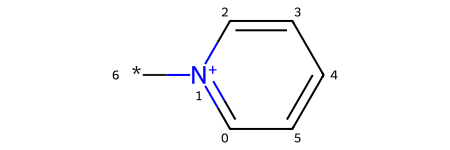

In [22]:
product = rwm.GetMol()
Chem.SanitizeMol(product)
product